# Play With SAM

In this notebook we try different post-processing for the masks given by SAM

In [9]:
import matplotlib.pyplot as plt
from utilsSAM import *
from SAM import SAMSegmenter
from alphaClip import AlphaClip


from datasets.dataset_vars import (
        COCO_CATEGORIES, 
        ADE20K_SEM_SEG_FULL_CATEGORIES as ADE20K_CATEGORIES
)

PATH_WEIGHT_SAM = 'checkpoints/sam_vit_h_4b8939.pth'
PATH_WEIGHT_ACLIP = 'checkpoints/clip_b16_grit+mim_fultune_4xe.pth'


In [10]:
image = cv2.imread('datasets/ADE20K_2021_17_01/images/ADE/training/cultural/apse__indoor/ADE_train_00001472.jpg')
    
segmenter = SAMSegmenter(model_type='vit_h', weight_path = PATH_WEIGHT_SAM)

classifier = AlphaClip(model_type='ViT-B/16', weight_path = PATH_WEIGHT_ACLIP)

Loading weight for SAM


/home/disi/miniconda3/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)
/home/disi/VF-

In [11]:

# Segment Image
masks = segmenter.predict_mask(image)

#Post Processing
# blurred_masks - red_circle_masks - bbox_masks - black_background_masks
images, masks = post_processing(masks, image, post_processing='red_circle_masks')
vocabulary = take_vocabulary(dataset = COCO_CATEGORIES)

# Classify Mask
logits = classifier.classify_mask(images, masks, vocabulary, flagUseAlpha = True)


predictions = logits.argmax(dim=-1)
values, indices = logits.cpu().topk(1)
for dim in range(len(values)):
    print("\n\nTop 5 predictions for mask ", dim)
    for value, index in zip(values[dim], indices[dim]):
        print(f"\t{vocabulary[index]}: {value.item()}")


--[INFO] post processing: create an empty red circle in the image--


Top 5 predictions for mask  0
	window-other: 0.4658203125


Top 5 predictions for mask  1
	window-other: 0.63330078125


Top 5 predictions for mask  2
	curtain: 0.53759765625


Top 5 predictions for mask  3
	structural-other: 0.61328125


Top 5 predictions for mask  4
	curtain: 0.44970703125


Top 5 predictions for mask  5
	window-other: 0.9931640625


Top 5 predictions for mask  6
	curtain: 0.7724609375


Top 5 predictions for mask  7
	light: 0.4375


Top 5 predictions for mask  8
	curtain: 0.60888671875


Top 5 predictions for mask  9
	table: 0.311767578125


Top 5 predictions for mask  10
	window-other: 0.49169921875


Top 5 predictions for mask  11
	curtain: 0.96484375


Top 5 predictions for mask  12
	structural-other: 0.426025390625


Top 5 predictions for mask  13
	window-other: 0.390625


Top 5 predictions for mask  14
	curtain: 0.50390625


Top 5 predictions for mask  15
	curtain: 0.9287109375


Top 5 predic

/tmp/ipykernel_8084/3718101931.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv', len(masks))


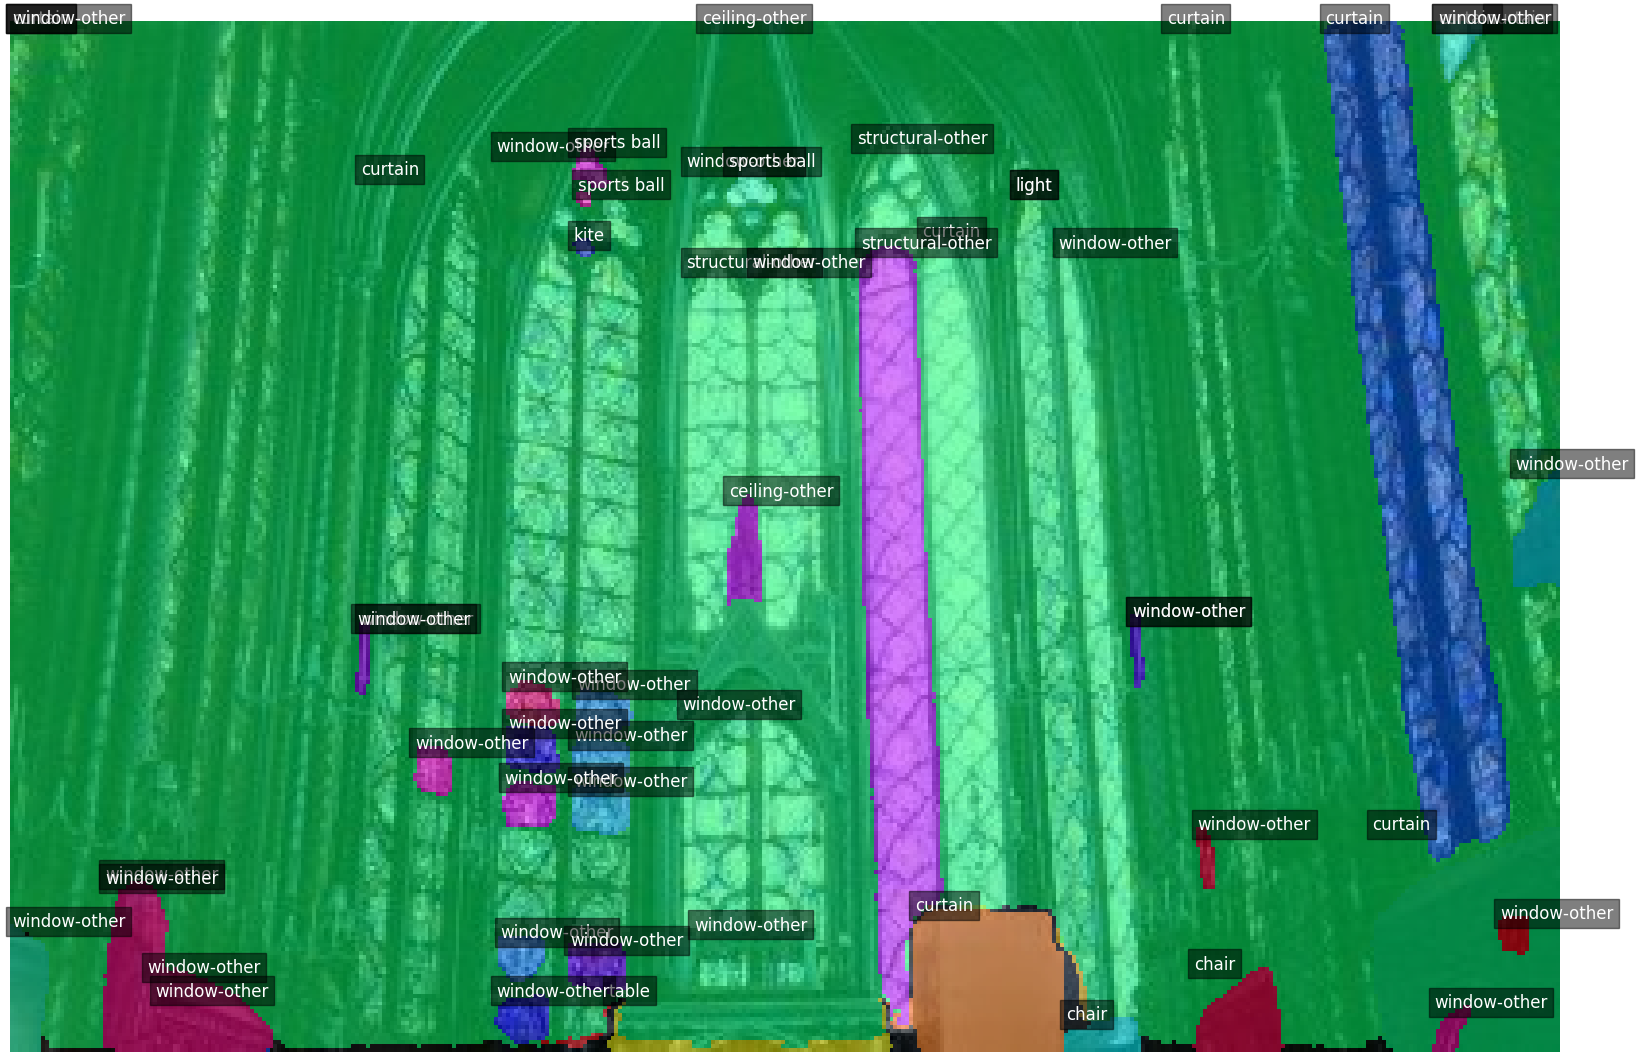

In [12]:
# Create a blank image with the same shape as the original image
recomposed_image = np.zeros_like(image)

# Define a list of colors for the masks
colors = plt.cm.get_cmap('hsv', len(masks))

# Iterate over the masks and apply the colors
for i, mask in enumerate(masks):
    color = colors(i)[:3]  # Get the RGB values from the colormap
    segmentation = mask['segmentation']
    recomposed_image[segmentation] = (np.array(color) * 255).astype(np.uint8)

# Overlay the recomposed image on the original image
overlay_image = cv2.addWeighted(image, 0.5, recomposed_image, 0.5, 0)

# Plot the overlay image with the top 1 prediction labels
plt.figure(figsize=(20, 20))
plt.imshow(overlay_image)
for i, mask in enumerate(masks):
    x, y, w, h = mask['bbox']
    plt.text(x, y, vocabulary[predictions[i]], color='white', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
plt.axis('off')
plt.show()